In [49]:
from Functions import *
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_csv('labeled_utterances.csv')

data.uids = data.uids.apply(eval)

In [3]:
data.columns

Index(['committee_position', 'pid', 'pid_next', 'simple_label_next', 'text',
       'text_next', 'uids', 'vid', 'question', 'procedural_question',
       'weak_question'],
      dtype='object')

In [4]:
len(data)

209

In [5]:
data.count()

committee_position     209
pid                    209
pid_next               206
simple_label_next      209
text                   209
text_next              209
uids                   209
vid                    209
question               209
procedural_question    209
weak_question          209
dtype: int64

In [6]:
data.question.value_counts()

False    123
True      86
Name: question, dtype: int64

In [7]:
data.simple_label_next.value_counts()

General Public       108
State Agency Rep      37
Bill Author           30
Unlabeled             13
Lobbyist              10
LAO                    8
Staff                  2
State Const Ofice      1
Name: simple_label_next, dtype: int64

## Looking at word frequency for questions vs non-questions

In [35]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
translator = str.maketrans(dict.fromkeys(string.punctuation))

In [40]:
data['processed_text'] = data.text.apply(preprocess_text, stemmer=stemmer, translator=translator, stop_words=stop_words)

## Trying to work out word frequencies

In [49]:
word_freq = get_word_freq(data.processed_text)

In [50]:
word_freq.head(10)

thank    0.056698
would    0.025849
bill     0.025704
go       0.021856
senat    0.019059
mr       0.018860
vote     0.018769
like     0.017305
well     0.017128
make     0.016876
dtype: float64

In [51]:
q_word_freq = get_word_freq(data.loc[data.question, 'processed_text'])

In [52]:
q_word_freq.head(10)

would       0.030838
thank       0.030248
bill        0.029078
question    0.027708
go          0.026579
get         0.023830
ani         0.023175
im          0.021493
say         0.020205
make        0.019811
dtype: float64

In [53]:
non_q_word_freq = get_word_freq(data.loc[~data.question, 'processed_text'])

In [54]:
non_q_word_freq.head(10)

thank     0.078829
vote      0.029321
bill      0.026602
senat     0.026315
would     0.025211
pleas     0.024619
item      0.023488
mr        0.023168
member    0.022789
wit       0.022244
dtype: float64

In [55]:
custom_stopwords = set(['bill', ])

## Finding least different word

In [56]:
q_df = q_word_freq.to_frame('q_tf_idf').reset_index().rename(columns={'index': 'word'})
non_q_df = non_q_word_freq.to_frame('non_q_tf_idf').reset_index().rename(columns={'index': 'word'})

In [57]:
df = q_df.merge(non_q_df, on='word')

In [58]:
df['score_diff'] = df.apply(lambda row: abs(row['q_tf_idf'] - row['non_q_tf_idf']), axis=1)
df['score_diff_pct'] = df.apply(lambda row: abs(1 - row.q_tf_idf / row.non_q_tf_idf)*100, axis=1)

In [59]:
# df.sort_values('score_diff', ascending=False, inplace=True)

In [60]:
df.sort_values('score_diff_pct', ascending=False, inplace=True)

In [61]:
df.head()

,word,q_tf_idf,non_q_tf_idf,score_diff,score_diff_pct
132,confus,0.007485,0.000279,0.007206,2580.496511
115,lower,0.008059,0.000368,0.007691,2091.711867
208,spend,0.005726,0.000279,0.005447,1950.530722
15,board,0.016402,0.000846,0.015556,1839.305260
172,cal,0.006317,0.000368,0.005949,1617.858168


## Episode II: A New Approach

In [65]:
all_text = ''.join(data.processed_text)
all_words = nltk.FreqDist(w for w in word_tokenize(all_text))

In [66]:
len(all_words)

2270

In [79]:
word_features = [w[0] for w in all_words.most_common()[:50]]

## Naive Bayes with TFIDF

In [97]:
vect = TfidfVectorizer()
X = vect.fit_transform(data.processed_text)
y = data.question

In [86]:
X_train_tfidf.shape

(209, 2108)

In [87]:
data.shape

(209, 12)

#### The Model

In [45]:
model = GaussianNB()

In [250]:
scores = cross_val_score(model, X.toarray(), y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.50239234449760761

#### Results

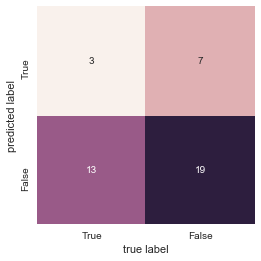

In [310]:
results = assess_results(model, X, y)

In [313]:
row = results['true_positive'].iloc[0]
row

committee_position                                            Vice-Chair
pid                                                                   14
pid_next                                                          108894
simple_label_next                                         General Public
text                   Thank you very much. If you could help me unde...
text_next              Yeah, so charter cities would be required to c...
uids                                                          {12002091}
vid                                                                26664
question                                                            True
procedural_question                                                False
weak_question                                                      False
processed_text         thank veri much could help understand affect c...
Name: 33, dtype: object

In [260]:
row.text

'Thank you very much. If you could help me understand how this affects charter cities and potential charter amendments that are required to be able to modify city charters.'

### Linear SVC for the sparse text matrix

In [164]:
vect = TfidfVectorizer()
X = vect.fit_transform(data.processed_text)
y = data.question

In [167]:
X.shape

(209, 2108)

#### The Model

In [168]:
model = LinearSVC(dual=False)

In [169]:
scores = cross_val_score(model, X.toarray(), y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.66985645933014359

#### Results

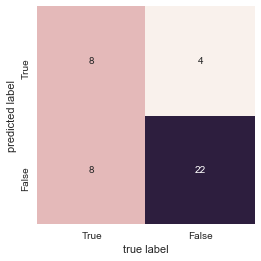

In [171]:
results = assess_results(model, X, y, data)

In [179]:
model = LogisticRegression()

In [180]:
scores = cross_val_score(model, X.toarray(), y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.62200956937799046

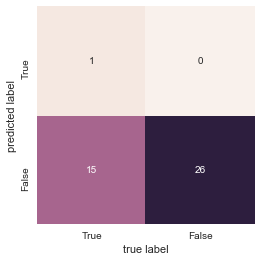

In [181]:
results = assess_results(model, X, y, data)

## Naive Bayes with Word Counts

In [186]:
vect = CountVectorizer()
X = vect.fit_transform(data.processed_text)
y = data.question

In [192]:
model = MultinomialNB()

In [193]:
scores = cross_val_score(model, X.toarray(), y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.66028708133971292

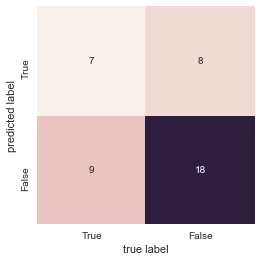

In [194]:
results = assess_results(model, X, y, data)

### Optimizing with Grid Search

In [205]:
from sklearn.grid_search import GridSearchCV

C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [211]:
vect = CountVectorizer()
X = vect.fit_transform(data.processed_text)
y = data.question

In [216]:
param_grid = {'alpha': np.linspace(0, 1, 100)}

In [217]:
grid = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=4)

In [218]:
grid.fit(X, y)

GridSearchCV(cv=4, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.    ,  0.0101, ...,  0.9899,  1.    ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [220]:
best = grid.best_params_

In [221]:
model = MultinomialNB(alpha=best['alpha'])

In [222]:
scores = cross_val_score(model, X.toarray(), y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.64114832535885169

## Linear SVC with Word Counts

In [195]:
vect = CountVectorizer()
X = vect.fit_transform(data.processed_text)
y = data.question

In [196]:
model = LinearSVC(dual=False)

In [197]:
scores = cross_val_score(model, X.toarray(), y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.58851674641148322

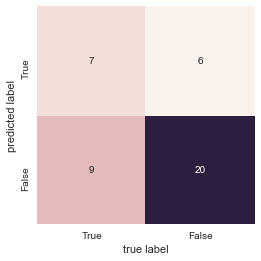

In [198]:
results = assess_results(model, X, y, data)

## Classifying Based on Other Features

Features:
1. simple_label_next
2. \# of words in question
3. \# of words in response
4. \# of question marks
5. Committee position

In [140]:
X = pd.get_dummies(data.simple_label_next)
# X = pd.concat([X, pd.get_dummies(data['committee_position'])], axis=1)
X['q_word_count'] = data.text.apply(lambda t: len(word_tokenize(t)))
X['q_uid_count'] = data.uids.apply(len)
X['r_word_count'] = data.text_next.apply(lambda t: len(word_tokenize(t)))
X['?_count'] = data.text.apply(lambda t: t.count('?'))
y = data.question

### Logisitic Regression

In [143]:
model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.87081339712918659

#### Results

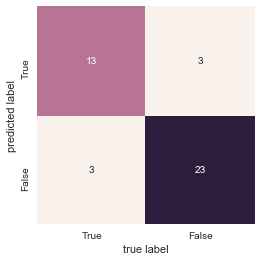

In [54]:
results = assess_results(model, X, y, data)

In [59]:
row = results['false_negative'].iloc[0]
row

committee_position                                                Member
pid                                                                  105
pid_next                                                              52
simple_label_next                                            Bill Author
text                   Thank you, Madam Chair. Senator, is there anyt...
text_next              Yes, I didn't put it as a, you're right, it's ...
uids                                                           {5080805}
vid                                                                 6374
question                                                            True
procedural_question                                                False
weak_question                                                      False
processed_text         thank madam chair senat anyth would ani requir...
Name: 22, dtype: object

In [60]:
row.text

"Thank you, Madam Chair. Senator, is there anything in here that would have any requirement of quality, just a matter of time they spend and they get past some threshold and they're going to get a bonus, or?"

### Random Forest

In [148]:
model = RandomForestClassifier()
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.86602870813397126

#### Results

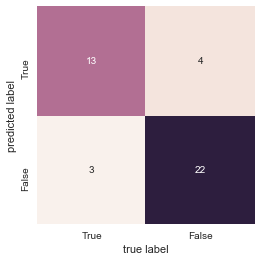

In [149]:
results = assess_results(model, X, y, data)

In [150]:
fp = results['false_positive']
row = fp.iloc[1]
row

committee_position                                 Member
pid                                                    31
pid_next                                            14856
simple_label_next                          General Public
text                   Ayes 74, Noes 0., Ayes 74, Noes 0.
text_next               Senate concur with resolution 44.
uids                                   {2692544, 2695252}
vid                                                  4223
question                                            False
procedural_question                                 False
weak_question                                       False
processed_text                  aye 74 noe 0 aye 74 noe 0
Name: 92, dtype: object

In [151]:
fp.committee_position.value_counts()

Member              2
Possible Chair      1
Not In Committee    1
Name: committee_position, dtype: int64

In [152]:
fp.simple_label_next.value_counts()

General Public    4
Name: simple_label_next, dtype: int64

In [153]:
fp.procedural_question

52      True
92     False
176     True
186    False
Name: procedural_question, dtype: bool

In [154]:
fp.weak_question

52     False
92     False
176    False
186     True
Name: weak_question, dtype: bool

### Linear SVC

In [157]:
model = LinearSVC(dual=True)
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.77033492822966509

#### Results

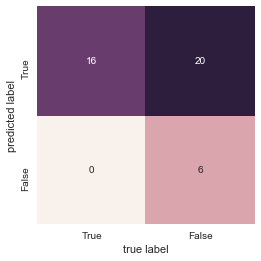

In [158]:
results = assess_results(model, X, y, data)

In [159]:
fp = results['false_positive']
row = fp.iloc[1]
row

committee_position                                                Member
pid                                                                   66
pid_next                                                             112
simple_label_next                                            Bill Author
text                   The bill has 9 votes. We will hold the roll op...
text_next              Thank you, members. Out of AB 987 will simply ...
uids                                                {14106004, 14106005}
vid                                                                28952
question                                                           False
procedural_question                                                False
weak_question                                                      False
processed_text         bill 9 vote hold roll open absent member well ...
Name: 12, dtype: object

In [160]:
fp.committee_position.value_counts()

Not In Committee    8
Possible Chair      6
Member              5
Vice-Chair          1
Name: committee_position, dtype: int64

In [161]:
fp.simple_label_next.value_counts()

General Public      12
Bill Author          2
State Agency Rep     2
Unlabeled            2
Staff                1
Lobbyist             1
Name: simple_label_next, dtype: int64

In [162]:
fp.procedural_question

7      False
12     False
37     False
45     False
66     False
71     False
75     False
80     False
124    False
134    False
135    False
138    False
149    False
154    False
158    False
170    False
176     True
184    False
186    False
187    False
Name: procedural_question, dtype: bool

In [163]:
fp.weak_question

7      False
12     False
37     False
45     False
66     False
71     False
75      True
80     False
124    False
134    False
135    False
138    False
149    False
154    False
158    False
170    False
176    False
184    False
186     True
187    False
Name: weak_question, dtype: bool

## Just Heuristics

In [103]:
class my_model(object):
    def fit(self, X, y):
        pass
    
    def predict(object, X):
        rule_1 = X.q_uid_count < 5
        rule_2 = X['?_count'] > 0
        rule_3 = ((X['General Public'] == 1) | 
                  (X['Bill Author'] == 1) |
                  (X['Lobbyist'] == 1) |
                  (X['LAO'] == 1) | 
                  (X['State Const Ofice'] == 1)) 
        
        return rule_1 & rule_2 & rule_3
        

In [87]:
X = pd.get_dummies(data.simple_label_next)
X['q_word_count'] = data.text.apply(lambda t: len(word_tokenize(t)))
X['q_uid_count'] = data.uids.apply(len)
X['r_word_count'] = data.text_next.apply(lambda t: len(word_tokenize(t)))
X['?_count'] = data.text.apply(lambda t: t.count('?'))
y = data.question

In [104]:
model = my_model()

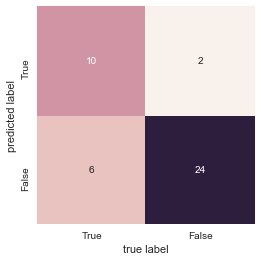

In [107]:
results = assess_results(model, X, y, data)

In [110]:
fp = results['false_positive']
row = fp.iloc[1]
row

committee_position                                        Possible Chair
pid                                                                   13
pid_next                                                           14925
simple_label_next                                         General Public
text                   So you're already there? Okay, good., San Bern...
text_next              As part of Casa, we fought really hard for tha...
uids                                                  {2913288, 2913290}
vid                                                                 4394
question                                                           False
procedural_question                                                False
weak_question                                                       True
processed_text         alreadi okay good san bernardino doesnt peopl ...
Name: 186, dtype: object

In [111]:
fp.committee_position.value_counts()

Possible Chair      1
Not In Committee    1
Name: committee_position, dtype: int64

In [112]:
fp.simple_label_next.value_counts()

General Public    2
Name: simple_label_next, dtype: int64

In [113]:
fp.procedural_question

176     True
186    False
Name: procedural_question, dtype: bool

In [114]:
fp.weak_question

176    False
186     True
Name: weak_question, dtype: bool

### Thoughts
False positives arise when questions are either weak or procedural. These are awfully hard to catch. 

### False Negatives

In [127]:
fn = results['false_negative']
row = fn.iloc[1]
row

committee_position                                                Member
pid                                                                   16
pid_next                                                          104121
simple_label_next                                       State Agency Rep
text                   And has there been any effort to encourage dep...
text_next              We have engaged departments and agencies that ...
uids                                                          {11324000}
vid                                                                24311
question                                                            True
procedural_question                                                False
weak_question                                                      False
processed_text         ani effort encourag depart dont author assess ...
Name: 83, dtype: object

In [128]:
row.text

"And has there been any effort to encourage departments that you don't have authority over to do assessments, audits, self-assessments? And do you know of any of the departments that are doing that?"

In [121]:
fn.committee_position.value_counts()

Member            4
Possible Chair    1
Vice-Chair        1
Name: committee_position, dtype: int64

In [122]:
fn.simple_label_next.value_counts()

State Agency Rep    5
General Public      1
Name: simple_label_next, dtype: int64

In [125]:
fn[['procedural_question', 'weak_question']]

,procedural_question,weak_question
33,False,False
83,False,False
86,False,False
90,False,False
156,False,False
189,False,False


### Thoughts
False negative appear to occur in cases where there is no question mark. Or they are talking to a state agency rep. 

## How well does tokenization work?

In [82]:
text = data.text.iloc[20]

In [85]:
text

'Thank you, Senator Jackson. Members, seeing no discussion or debate, is there any objection to using a unanimous roll call? Seeing none, ayes 39, nos 0, measure passes. File Item 142, Senator Jackson, Mr. Secretary, please read.'

In [86]:
lst = sent_tokenize(text)

Oh shit, it works great

In [87]:
lst

['Thank you, Senator Jackson.',
 'Members, seeing no discussion or debate, is there any objection to using a unanimous roll call?',
 'Seeing none, ayes 39, nos 0, measure passes.',
 'File Item 142, Senator Jackson, Mr. Secretary, please read.']

# Parse Trees

In [228]:
from pycorenlp import StanfordCoreNLP

In [229]:
nlp = StanfordCoreNLP('http://localhost:9000')

In [274]:
syntactic_targets = set(['ADJP',
                         'ADVP',
                         'NP', 
                         'PP', 
                         'S', 
                         'SBAR', 
                         'SBARQ', 
                         'SINV', 
                         'SQ',
                         'VP', 
                         'WHADVP', 
                         'WHNP', 
                         'WHPP'])

In [281]:
text = """Hi Bob. And that works for the bill, correct?"""

In [302]:
data['syn_tags'] = data.text.apply(stanford_parse, nlp=nlp, syntactic_targets=syntactic_targets)

### Heuristic Based

In [367]:
question_tags = set(w.lower() for w in ['SBARQ', 'SQ', 'WHADVP', 'WHNP', 'WHPP', 'SINV'])


In [368]:
cnt_vect = CountVectorizer()

In [369]:
bag_of_tags = cnt_vect.fit_transform(data.syn_tags)

In [371]:
# You should be careful about this once your feature sets gets larger
X = pd.DataFrame(bag_of_tags.toarray(), columns=cnt_vect.get_feature_names())
X = X.loc[:,X.columns.isin(question_tags)]

y = data.question

In [380]:
class my_model(object):
    def fit(self, X, y):
        pass
    
    def predict(object, X):
        rule = X.apply(sum, axis=1) > 0
        
        return rule
        

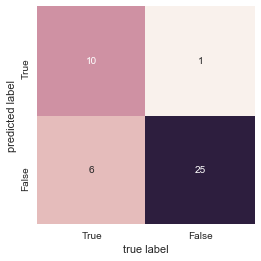

In [381]:
results = assess_results(model, X, y, data)

In [386]:
fp = results['false_positive']

In [388]:
row = fp.iloc[0]
row

committee_position                                      Not In Committee
pid                                                                   83
pid_next                                                             431
simple_label_next                                         General Public
text                   Thank you. Is there anyone else in opposition?...
text_next              Thank you Assembly Member, Alice Kessler here ...
uids                                                           {1291267}
vid                                                                 1248
question                                                           False
procedural_question                                                 True
weak_question                                                      False
processed_text         thank anyon els opposit testimoni pleas come m...
syn_tags               S VP NP SQ NP NP NP PP NP PP NP S VP VP VP PP ...
Name: 176, dtype: object

In [389]:
row.text

'Thank you. Is there anyone else in opposition? With testimony? Please come to the mic then and state your name and your organization.'

In [390]:
fn = results['false_negative']

In [392]:
fn.simple_label_next.value_counts()

General Public      4
State Agency Rep    2
Name: simple_label_next, dtype: int64

In [391]:
row = fn.iloc[0]
row

committee_position                                            Vice-Chair
pid                                                                   14
pid_next                                                          108894
simple_label_next                                         General Public
text                   Thank you very much. If you could help me unde...
text_next              Yeah, so charter cities would be required to c...
uids                                                          {12002091}
vid                                                                26664
question                                                            True
procedural_question                                                False
weak_question                                                      False
processed_text         thank veri much could help understand affect c...
syn_tags               S VP NP ADVP S SBAR S NP VP VP NP VP SBAR WHAD...
Name: 33, dtype: object

In [394]:
sent_tokenize(row.text)

['Thank you very much.',
 'If you could help me understand how this affects charter cities and potential charter amendments that are required to be able to modify city charters.']

In [395]:
print_parse_tree(_394[1])

(ROOT
  (S
    (SBAR (IN If)
      (S
        (NP (PRP you))
        (VP (MD could)
          (VP (VB help)
            (NP (PRP me))))))
    (VP (VB understand)
      (SBAR
        (WHADVP (WRB how))
        (S
          (NP (DT this))
          (VP (VBZ affects)
            (NP
              (NP (NN charter) (NNS cities))
              (CC and)
              (NP
                (NP (JJ potential) (NN charter) (NNS amendments))
                (SBAR
                  (WHNP (WDT that))
                  (S
                    (VP (VBP are)
                      (VP (VBN required)
                        (S
                          (VP (TO to)
                            (VP (VB be)
                              (ADJP (JJ able)
                                (S
                                  (VP (TO to)
                                    (VP (VB modify)
                                      (NP (NN city) (NNS charters)))))))))))))))))))
    (. .)))


In [396]:
row.processed_text

'thank veri much could help understand affect charter citi potenti charter amend requir abl modifi citi charter'

## Naive Bayes and Parse Trees

In [408]:
X = pd.DataFrame(bag_of_tags.toarray(), columns=cnt_vect.get_feature_names())
y = data.question

In [409]:
model = MultinomialNB()

In [410]:
scores = cross_val_score(model, X, y, cv=LeaveOneOut(X.shape[0]))
scores.mean()

0.75598086124401909

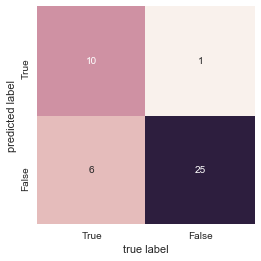

In [411]:
results = assess_results(model, X, y, data)

In [404]:
fp, fn = results['false_positive'], results['false_negative']

In [406]:
row = fp.iloc[0]
row

committee_position                                      Not In Committee
pid                                                                   83
pid_next                                                             431
simple_label_next                                         General Public
text                   Thank you. Is there anyone else in opposition?...
text_next              Thank you Assembly Member, Alice Kessler here ...
uids                                                           {1291267}
vid                                                                 1248
question                                                           False
procedural_question                                                 True
weak_question                                                      False
processed_text         thank anyon els opposit testimoni pleas come m...
syn_tags               S VP NP SQ NP NP NP PP NP PP NP S VP VP VP PP ...
Name: 176, dtype: object

In [407]:
fn.simple_label_next.value_counts()

General Public      4
State Agency Rep    2
Name: simple_label_next, dtype: int64

In [ ]:
def vectorize_text(vect, field, data, prepend):
    "Vectorizes text and appends new fields to data. Returns new dataframe and the names of the columns"
    scores = vect.fit_transform(data[field])
    scores = pd.DataFrame(scores.toarray(), columns=vect.get_feature_names())
    
    scores_cols = [prepend + c for c in scores.columns]
    scores.columns = scores_cols
    
    data = pd.concat([data, scores], axis=1)
    
    return data, scores_cols

In [431]:
data[data.question].text.sample()

5    Couple of a questions and a comment. One is ho...
Name: text, dtype: object

In [432]:
data.iloc[5]

committee_position                                                Member
pid                                                                   80
pid_next                                                          100927
simple_label_next                                            Bill Author
text                   Couple of a questions and a comment. One is ho...
text_next              So, as to the first question, I think it's an ...
uids                                                          {11200169}
vid                                                                24218
question                                                            True
procedural_question                                                False
weak_question                                                      False
processed_text         coupl question comment one think alreadi answe...
syn_tags               NP NP PP NP NP NP S S NP VP SBAR WHADVP S NP V...
Name: 5, dtype: object

In [433]:
_.text

"Couple of a questions and a comment. One is how, I think it was already answered, I was going to ask you why do need a statewide goal if water agencies are all ready using desal as an option? Two, how do you account for the increased GHG emissions basically caused by desalinization since it's pretty energy intensive? The reason why I'm asking that, we just passed a bill, Bigelow's, based on the fact that his bill would actually decrease GHG emissions by"